## Assignment 1 Euler-Bernoulli's beam

In [ ]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as ticker

x, L, q0, P, E, I = symbols('x L q0 P E I')

w = Function('w')(x) # w is a function of x

diffeq1 = Eq(E*I * diff(w, x, 4), q0)

w = dsolve(diffeq1, w).rhs

M = -E*I*w.diff(x, 2)

#C1, C2, C3, C4 = symbols('C1 C2 C3 C4')

# Boundary conditions for distributed load
boundary_conditions1 = [ w.subs(x, 0),                      #w(0) = 0
                        w.diff(x).subs(x, 0),                 #w'(0) = 0
                        M.subs(x, L),                       #w''(L) = 0
                        w.diff(x,3).subs(x, L) - P/(-E*I)]      #w'''(L) = -P

integration_constants = solve(boundary_conditions1, 'C1, C2, C3, C4', real=True)

display(integration_constants)

solution = w.subs(integration_constants)

display(simplify(solution))

w_func = lambdify((x, L, q0, P, E, I), solution, 'numpy')

# Numerical values
L1 = 3; L2 = 0.3

L=L1
E=220e9
b=h=0.05
I = b*h**3/12; #moment of inertia
rho = 7800; #density
g = 9.81
m = 130
P = -m*g
poisson = 0.3
q0 = -h*b*rho*g

x_vals = np.linspace(0, L, 200)
w_vals = w_func(x_vals, L, q0, P, E, I)

plt.figure(figsize=(10,6))
plt.plot(x_vals, w_vals*1e3, 'b-', linewidth=2)
plt.title('Beam Deflection under Combined Loading at L=3', fontsize=16)
plt.xlabel('Position along beam (m)', fontsize=14)
plt.ylabel('Deflection (mm)', fontsize=14)
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.ylim(bottom=min(w_vals)*1e3*1.1)
plt.xlim(0, L)
plt.show()

L=L2


x_vals = np.linspace(0, L, 200)
w_vals = w_func(x_vals, L, q0, P, E, I)

plt.figure(figsize=(10,6))
plt.plot(x_vals, w_vals*1e3, 'b-', linewidth=2)
plt.title('Beam Deflection under Combined Loading at L=0.3', fontsize=16)
plt.xlabel('Position along beam (m)', fontsize=14)
plt.ylabel('Deflection (mm)', fontsize=14)
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.ylim(bottom=min(w_vals)*1e3*1.1)
plt.xlim(0, L)
plt.show()


## Timoshenko beam theory

In [ ]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt

#############
# Poiint load

x, q0, E, I, Ks, G, A, L, P = symbols('x q0 E I Ks G A L P', real=True)

f_phi = Function('phi') # phi is a function of x

## Define the differential equation in terms of phi
diffeq_phi = Eq(E*I*f_phi(x).diff(x, 3), q0)

## Solve the differential equation for phi(x) (eq. 3.35 LN)
phi = dsolve(diffeq_phi, f_phi(x)).rhs

## Solve the differential equation for w(x) (eq. 3.36 LN)
w = Function('w') # w is a function of x
diffeq_w = Eq(w(x).diff(x), -E*I/(G*Ks*A)*phi.diff(x,2) + phi)
w        = dsolve(diffeq_w, w(x)).rhs

## Define boundary conditions
M = -E*I*phi.diff(x)
# Boundary conditions for distributed load
boundary_conditions = [ w.subs(x, 0),                      #w(0) = 0
                        w.diff(x).subs(x, 0),                 #w'(0) = 0
                        M.subs(x, L),                       #w''(L) = 0
                        w.diff(x,3).subs(x, L) - P/(-E*I)]      #w'''(L) = -P

## Solve for the integration constants
integration_constants = solve(boundary_conditions, 'C1, C2, C3, C4', real=True)

## Substitute the integration constants into the solution
solution1 = w.subs(integration_constants)

display(solution1)

w_func = lambdify((x, L, q0, P, E, I, Ks, A, G), solution1, 'numpy')

# Numerical values
L1 = 3; L2 = 0.3

L=L1
E=220e9
b=h=0.05
I = b*h**3/12; #moment of inertia
rho = 7800; #density
g = 9.81
m = 130
P = -m*g
poisson = 0.3
q0 = -h*b*rho*g
Ks = 5/6
A = b*h
G = E/(2*(1+poisson))    

x_vals = np.linspace(0, L, 200)
w_vals = w_func(x_vals, L, q0, P, E, I, A, G, Ks)

plt.figure(figsize=(10,6))
plt.plot(x_vals, w_vals*1e3, 'b-', linewidth=2)
plt.title('Beam Deflection under Combined Loading at L=3', fontsize=16)
plt.xlabel('Position along beam (m)', fontsize=14)
plt.ylabel('Deflection (mm)', fontsize=14)
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.ylim(bottom=min(w_vals)*1e3*1.1)
plt.xlim(0, L)
plt.show()


# Numerical values
L1 = 3; L2 = 0.3

L=L2
q0 = -((m*g)/L2)

x_vals = np.linspace(0, L, 200)
w_vals = w_func(x_vals, L, q0, P, E, I, A, G, Ks)

plt.figure(figsize=(10,6))
plt.plot(x_vals, w_vals*1e3, 'b-', linewidth=2)
plt.title('Beam Deflection under Combined Loading at L=0.3', fontsize=16)
plt.xlabel('Position along beam (m)', fontsize=14)
plt.ylabel('Deflection (mm)', fontsize=14)
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.ylim(bottom=min(w_vals)*1e3*1.1)
plt.xlim(0, L)
plt.show()

## Problem 1 calfem

In [ ]:
from quadmesh import *
import numpy as np
import calfem.core as cfc
import calfem.vis_mpl as cfv

# Geometry
L1 = 3.0
L2 = 0.3
h = b = 0.05

# Material data
E = 220e9
poisson = 0.3
ptype = 1  # plane stress
ep = [ptype, b]  # [ptype, thickness]
Dmat = cfc.hooke(ptype, E, poisson)

# Physical properties
rho = 7800  # density
g = 9.81
m = 130
A = b * h

# Forces
P = -m * g  # Point load (downward, negative y-direction)
q0 = -h * b * rho * g  # Distributed load per unit length (downward)

# Create mesh
p1 = np.array([0., 0.])  # Lower left corner
p2 = np.array([L1, h])   # Upper right corner
nelx = 20
nely = 4
ndof_per_node = 2
nnode = (nelx + 1) * (nely + 1)
nDofs = ndof_per_node * nnode

# Create and plot rectangular mesh using quadmesh.py 

height = h
thickness = b

p1 = np.array([0., 0.]) # Lower left corner
p2 = np.array([L1, height]) # Upper right corner

nelx = 20; nely = 4 # Number of elements in x and y direction

ndof_per_node = 2 # Number of dofs per node
nnode = (nelx+1) * (nely+1) # Number of nodes
nDofs = ndof_per_node * nnode # Number of degrees of freedom

eq = [0, -q0]


# Generating mesh

Ex, Ey, Edof, B1, B2, B3, B4, P1, P2, P3, P4 = quadmesh(p1, p2, nelx, nely, ndof_per_node)
cfv.eldraw2(Ex, Ey) # Plotting the mesh

#display(Edof)
#display("Ex", Ex)

## Initializing boundary condition vectors

bc = np.array([], 'i')
bc_val = np.array([], 'f')
bc = B4
bcval = 0. * np.ones(np.size(bc))

display(bc)

# Initializing empty stiffness matrix
K = np.zeros([nDofs, nDofs])
f = np.zeros((nDofs, 1))

for eltopo, elx, ely, in zip(Edof, Ex, Ey):
    Ke = cfc.planqe(elx, ely, ep, Dmat)
    cfc.assem(eltopo, K, Ke)

top_elements = range(nelx * (nely - 1), nelx * nely)

for el_idx in top_elements:
    # Get element coordinates
    elx = Ex[el_idx, :]
    ely = Ey[el_idx, :]
    
    # Get element topology
    eltopo = Edof[el_idx, :]
    
    # For a quad element, the top edge connects nodes at indices 2 and 3
    # Calculate edge length
    edge_length = np.sqrt((elx[2] - elx[3])**2 + (ely[2] - ely[3])**2)
    
    # Equivalent nodal forces for uniform distributed load
    # For a uniformly distributed load q over length L:
    # Each node gets q*L/2
    nodal_force = q0 * edge_length / 2.0
    
    # Apply to the y-DOFs of nodes 3 and 4 (indices 4,5,6,7 in eltopo)
    # Node 3 (top-right): eltopo[4] = x-dof, eltopo[5] = y-dof
    # Node 4 (top-left): eltopo[6] = x-dof, eltopo[7] = y-dof
    f[eltopo[5] - 1] += nodal_force  # y-DOF of node 3 (0-indexed)
    f[eltopo[7] - 1] += nodal_force  # y-DOF of node 4 (0-indexed)

# Apply point load P at top right corner (P3)
# P3 contains the DOFs of the top-right corner node
f[P3[1] - 1] += P  # y-direction DOF (subtract 1 for 0-indexing)

print(f"Total distributed load: {q0 * L1:.2f} N")
print(f"Point load: {P:.2f} N")
print(f"Total load: {q0 * L1 + P:.2f} N")

# Apply boundary conditions - fixed left edge (B4)
bc = B4
bcval = np.zeros(np.size(bc))

# Solve the system
a, r = cfc.solveq(K, f, bc, bcval)

# Extract displacements
print(f"\nMaximum displacement: {np.min(a):.6e} m")
print(f"Maximum displacement (mm): {np.min(a)*1000:.4f} mm")






In [ ]:
for eltopo, elx, ely, in zip(Edof, Ex, Ey):
    Ke = cfc.planqe(elx, ely, ep, Dmat)
    fe = 
    cfc.assem(eltopo, K, Ke)

f[-1] += F

a, 

## Calfem with length 3m actual

In [ ]:
from quadmesh import *
import numpy as np
import calfem.core as cfc
import calfem.vis_mpl as cfv
import matplotlib.pyplot as plt
# Geometry
L1 = 3.0
L2 = 0.3
h = b = 0.05

# Material data
E = 220e9
poisson = 0.3
ptype = 1  # plane stress
ep = [ptype, b]  # [ptype, thickness]
Dmat = cfc.hooke(ptype, E, poisson)

# Physical properties
rho = 7800  # density
g = 9.81
m = 130
A = b * h

# Forces
P = -m * g  # Point load (downward, negative y-direction)
q0 = -h * b * rho * g  # Distributed load per unit length (downward)

# Create mesh
p1 = np.array([0., 0.])  # Lower left corner
p2 = np.array([L1, h])   # Upper right corner
nelx = 20
nely = 4
ndof_per_node = 2
nnode = (nelx + 1) * (nely + 1)
nDofs = ndof_per_node * nnode

# Generate mesh
Ex, Ey, Edof, B1, B2, B3, B4, P1, P2, P3, P4 = quadmesh(p1, p2, nelx, nely, ndof_per_node)

# Plot mesh
cfv.figure()
cfv.eldraw2(Ex, Ey)
cfv.title('Mesh')
cfv.show()

display(B2)



# Initialize global stiffness matrix and force vector
K = np.zeros([nDofs, nDofs])
f = np.zeros([nDofs, 1])

# Assemble stiffness matrix
for eltopo, elx, ely in zip(Edof, Ex, Ey):
    Ke = cfc.planqe(elx, ely, ep, Dmat)
    cfc.assem(eltopo, K, Ke)

# Apply distributed load on top edge (B3)
# For a uniformly distributed load on a line element, the equivalent nodal forces
# are q*L/2 at each node (where L is the length of the edge)

# Find which elements have their top edge on B3
# Top edge elements are those in the top row (last nely row)
top_elements = range(nelx * (nely - 1), nelx * nely)


for el_idx in top_elements:
    # Get element coordinates
    elx = Ex[el_idx, :]
    ely = Ey[el_idx, :]
    
    # Get element topology
    eltopo = Edof[el_idx, :]
    
    # For a quad element, the top edge connects nodes at indices 2 and 3
    # Calculate edge length
    edge_length = np.sqrt((elx[2] - elx[3])**2 + (ely[2] - ely[3])**2)
    
    # Equivalent nodal forces for uniform distributed load
    # For a uniformly distributed load q over length L:
    # Each node gets q*L/2
    nodal_force = q0 * edge_length / 2.0
    
    # Apply to the y-DOFs of nodes 3 and 4 (indices 4,5,6,7 in eltopo)
    # Node 3 (top-right): eltopo[4] = x-dof, eltopo[5] = y-dof
    # Node 4 (top-left): eltopo[6] = x-dof, eltopo[7] = y-dof
    f[eltopo[5] - 1] += nodal_force  # y-DOF of node 3 (0-indexed)
    f[eltopo[7] - 1] += nodal_force  # y-DOF of node 4 (0-indexed)

# Apply point load P at top right corner (P3)
# P3 contains the DOFs of the top-right corner node
#f[P3[1] - 1] += P  # y-direction DOF (subtract 1 for 0-indexing)
f[B2[0]] += P


print(f"Total distributed load: {q0 * L1:.2f} N")
print(f"Point load: {P:.2f} N")
print(f"Total load: {q0 * L1 + P:.2f} N")

# Apply boundary conditions - fixed left edge (B4)
bc = B4
bcval = np.zeros(np.size(bc))

# Solve the system
a, r = cfc.solveq(K, f, bc, bcval)

# Extract displacements
print(f"\nMaximum displacement: {np.min(a):.6e} m")
print(f"Maximum displacement (mm): {np.min(a)*1000:.4f} mm")

Ed = cfc.extract_eldisp(Edof, a)

# Deformations
plt.figure()
plotpar = [2, 1, 0]  # Plotting parameters
cfv.eldraw2(Ex, Ey, plotpar)  # Drawing the original geometry
plt.title('Original geometry')
# Drawing the deformed structure
#sfac = cfv.scalfact2(Ex[2, :], Ey[2, :], Ed[2, :], 1)
#plotpar = [1, 2, 1]
#sfac = 40  # Scaling factor to see the actual deformations
#cfv.eldisp2(Ex, Ey, Ed, plotpar, sfac)
#plt.title('Displacement')

# -------------------------------
# Plot undeformed and deformed mesh manually
# -------------------------------

# Compute nodal coordinates
xv = np.linspace(p1[0], p2[0], nelx + 1)
yv = np.linspace(p1[1], p2[1], nely + 1)
coords = np.array([[x, y] for y in yv for x in xv])  # (N, 2) array

# Deformed coordinates
U = a[0::2].reshape(-1, 1)  # x-displacements
V = a[1::2].reshape(-1, 1)  # y-displacements

sfac = 10  # deformation scale
coords_def = coords + sfac * np.hstack([U, V])

# Plot
plt.figure(figsize=(10, 3))
for elx, ely in zip(Ex, Ey):
    # Undeformed
    plt.plot(np.append(elx, elx[0]), np.append(ely, ely[0]), 'k-', lw=0.8, alpha=0.5)

for e, (elx, ely) in enumerate(zip(Ex, Ey)):
    # Get the deformed coordinates for each element
    nodes = ((Edof[e, ::ndof_per_node] - 1) // ndof_per_node).astype(int)
    x_def = coords_def[nodes, 0]
    y_def = coords_def[nodes, 1]
    plt.plot(np.append(x_def, x_def[0]), np.append(y_def, y_def[0]), 'r-', lw=1.0)

plt.gca().set_aspect('equal')
plt.title(f"Deformed mesh (scale factor = {sfac:.1f})")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.show()


## Calfem with length 0.3m actual

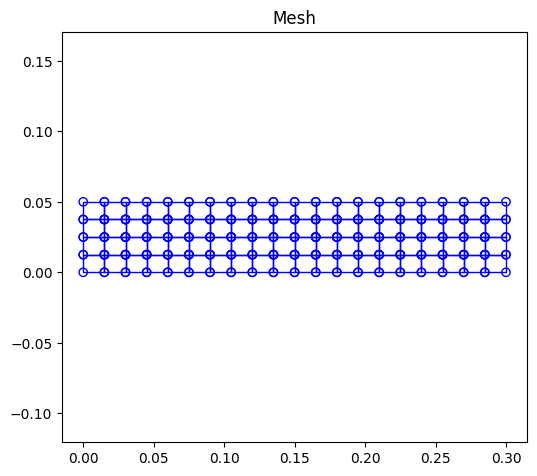

array([ 41,  42,  83,  84, 125, 126, 167, 168, 209, 210], dtype=int32)

Total distributed load: -573.89 N
Point load: -1275.30 N
Total load: -1849.18 N

Maximum displacement: -9.815038e-05 m
Maximum displacement (mm): -0.0982 mm


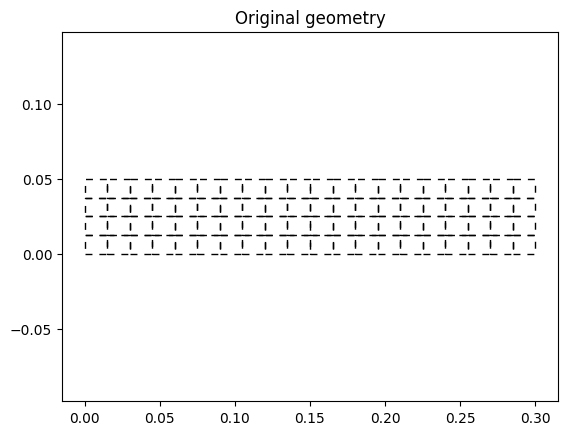

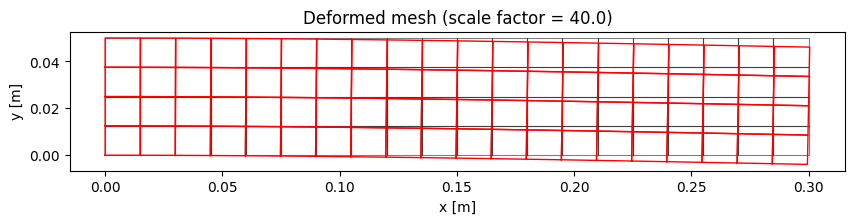

In [ ]:
from quadmesh import *
import numpy as np
import calfem.core as cfc
import calfem.vis_mpl as cfv
import matplotlib.pyplot as plt
# Geometry
L1 = 3.0
L2 = 0.3
h = b = 0.05

# Material data
E = 220e9
poisson = 0.3
ptype = 1  # plane stress
ep = [ptype, b]  # [ptype, thickness]
Dmat = cfc.hooke(ptype, E, poisson)

# Physical properties
rho = 7800  # density
g = 9.81
m = 130
A = b * h

# Forces
P = -m * g  # Point load (downward, negative y-direction)
q0 = -h * b * rho * g  # Distributed load per unit length (downward)

# Create mesh
p1 = np.array([0., 0.])  # Lower left corner
p2 = np.array([L2, h])   # Upper right corner
nelx = 20
nely = 4
ndof_per_node = 2
nnode = (nelx + 1) * (nely + 1)
nDofs = ndof_per_node * nnode

# Generate mesh
Ex, Ey, Edof, B1, B2, B3, B4, P1, P2, P3, P4 = quadmesh(p1, p2, nelx, nely, ndof_per_node)

# Plot mesh
cfv.figure()
cfv.eldraw2(Ex, Ey)
cfv.title('Mesh')
cfv.show()

display(B2)


# Initialize global stiffness matrix and force vector
K = np.zeros([nDofs, nDofs])
f = np.zeros([nDofs, 1])

# Assemble stiffness matrix
for eltopo, elx, ely in zip(Edof, Ex, Ey):
    Ke = cfc.planqe(elx, ely, ep, Dmat)
    cfc.assem(eltopo, K, Ke)

# Apply distributed load on top edge (B3)
# For a uniformly distributed load on a line element, the equivalent nodal forces
# are q*L/2 at each node (where L is the length of the edge)

# Find which elements have their top edge on B3
# Top edge elements are those in the top row (last nely row)
top_elements = range(nelx * (nely - 1), nelx * nely)


for el_idx in top_elements:
    # Get element coordinates
    elx = Ex[el_idx, :]
    ely = Ey[el_idx, :]
    
    # Get element topology
    eltopo = Edof[el_idx, :]
    
    # For a quad element, the top edge connects nodes at indices 2 and 3
    # Calculate edge length
    #edge_length = np.sqrt((elx[2] - elx[3])**2 + (ely[2] - ely[3])**2)
    L = np.hypot(elx[2] - elx[3], ely[2] - ely[3])

    # Equivalent nodal forces for uniform distributed load
    # For a uniformly distributed load q over length L:
    # Each node gets q*L/2
    nodal_force = q0 * L / 2.0
    
    # Apply to the y-DOFs of nodes 3 and 4 (indices 4,5,6,7 in eltopo)
    # Node 3 (top-right): eltopo[4] = x-dof, eltopo[5] = y-dof
    # Node 4 (top-left): eltopo[6] = x-dof, eltopo[7] = y-dof
    f[eltopo[5] - 1] += nodal_force  # y-DOF of node 3 (0-indexed)
    f[eltopo[7] - 1] += nodal_force  # y-DOF of node 4 (0-indexed)

# Apply point load P at top right corner (P3)
# P3 contains the DOFs of the top-right corner node
#f[P3[1] - 1] += P  # y-direction DOF (subtract 1 for 0-indexing)
f[B2[0]] += P


print(f"Total distributed load: {q0 * L1:.2f} N")
print(f"Point load: {P:.2f} N")
print(f"Total load: {q0 * L1 + P:.2f} N")

# Apply boundary conditions - fixed left edge (B4)
bc = B4
bcval = np.zeros(np.size(bc))

# Solve the system
a, r = cfc.solveq(K, f, bc, bcval)

# Extract displacements
print(f"\nMaximum displacement: {np.min(a):.6e} m")
print(f"Maximum displacement (mm): {np.min(a)*1000:.4f} mm")

Ed = cfc.extract_eldisp(Edof, a)

# Deformations
plt.figure()
plotpar = [2, 1, 0]  # Plotting parameters
cfv.eldraw2(Ex, Ey, plotpar)  # Drawing the original geometry
plt.title('Original geometry')
# Drawing the deformed structure
#sfac = cfv.scalfact2(Ex[2, :], Ey[2, :], Ed[2, :], 1)
#plotpar = [1, 2, 1]
#sfac = 40  # Scaling factor to see the actual deformations
#cfv.eldisp2(Ex, Ey, Ed, plotpar, sfac)
#plt.title('Displacement')

# -------------------------------
# Plot undeformed and deformed mesh manually
# -------------------------------

# Compute nodal coordinates
xv = np.linspace(p1[0], p2[0], nelx + 1)
yv = np.linspace(p1[1], p2[1], nely + 1)
coords = np.array([[x, y] for y in yv for x in xv])  # (N, 2) array

# Deformed coordinates
U = a[0::2].reshape(-1, 1)  # x-displacements
V = a[1::2].reshape(-1, 1)  # y-displacements

sfac = 40  # deformation scale
coords_def = coords + sfac * np.hstack([U, V])

# Plot
plt.figure(figsize=(10, 3))
for elx, ely in zip(Ex, Ey):
    # Undeformed
    plt.plot(np.append(elx, elx[0]), np.append(ely, ely[0]), 'k-', lw=0.8, alpha=0.5)

for e, (elx, ely) in enumerate(zip(Ex, Ey)):
    # Get the deformed coordinates for each element
    nodes = ((Edof[e, ::ndof_per_node] - 1) // ndof_per_node).astype(int)
    x_def = coords_def[nodes, 0]
    y_def = coords_def[nodes, 1]
    plt.plot(np.append(x_def, x_def[0]), np.append(y_def, y_def[0]), 'r-', lw=1.0)

plt.gca().set_aspect('equal')
plt.title(f"Deformed mesh (scale factor = {sfac:.1f})")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.show()


## Backup

In [ ]:
from quadmesh import *
import numpy as np
import calfem.core as cfc
import calfem.vis_mpl as cfv

# Geometry
L1 = 3.0
L2 = 0.3
h = b = 0.05

# Material data
E = 220e9
poisson = 0.3
ptype = 1  # plane stress
ep = [ptype, b]  # [ptype, thickness]
Dmat = cfc.hooke(ptype, E, poisson)

# Physical properties
rho = 7800  # density
g = 9.81
m = 130
A = b * h

# Forces
P = -m * g  # Point load (downward, negative y-direction)
q0 = -h * b * rho * g  # Distributed load per unit length (downward)

# Create mesh
p1 = np.array([0., 0.])  # Lower left corner
p2 = np.array([L1, h])   # Upper right corner
nelx = 20
nely = 4
ndof_per_node = 2
nnode = (nelx + 1) * (nely + 1)
nDofs = ndof_per_node * nnode

# Generate mesh
Ex, Ey, Edof, B1, B2, B3, B4, P1, P2, P3, P4 = quadmesh(p1, p2, nelx, nely, ndof_per_node)

# Plot mesh
cfv.figure()
cfv.eldraw2(Ex, Ey)
cfv.title('Mesh')

# Initialize global stiffness matrix and force vector
K = np.zeros([nDofs, nDofs])
f = np.zeros([nDofs, 1])

# Assemble stiffness matrix
for eltopo, elx, ely in zip(Edof, Ex, Ey):
    Ke = cfc.planqe(elx, ely, ep, Dmat)
    cfc.assem(eltopo, K, Ke)

# Apply distributed load on top edge (B3)
# For a uniformly distributed load on a line element, the equivalent nodal forces
# are q*L/2 at each node (where L is the length of the edge)

# Find which elements have their top edge on B3
# Top edge elements are those in the top row (last nely row)
top_elements = range(nelx * (nely - 1), nelx * nely)

for el_idx in top_elements:
    # Get element coordinates
    elx = Ex[el_idx, :]
    ely = Ey[el_idx, :]
    
    # Get element topology
    eltopo = Edof[el_idx, :]
    
    # For a quad element, the top edge connects nodes at indices 2 and 3
    # Calculate edge length
    edge_length = np.sqrt((elx[2] - elx[3])**2 + (ely[2] - ely[3])**2)
    
    # Equivalent nodal forces for uniform distributed load
    # For a uniformly distributed load q over length L:
    # Each node gets q*L/2
    nodal_force = q0 * edge_length / 2.0
    
    # Apply to the y-DOFs of nodes 3 and 4 (indices 4,5,6,7 in eltopo)
    # Node 3 (top-right): eltopo[4] = x-dof, eltopo[5] = y-dof
    # Node 4 (top-left): eltopo[6] = x-dof, eltopo[7] = y-dof
    f[eltopo[5] - 1] += nodal_force  # y-DOF of node 3 (0-indexed)
    f[eltopo[7] - 1] += nodal_force  # y-DOF of node 4 (0-indexed)

# Apply point load P at top right corner (P3)
# P3 contains the DOFs of the top-right corner node
f[P3[1] - 1] += P  # y-direction DOF (subtract 1 for 0-indexing)

print(f"Total distributed load: {q0 * L1:.2f} N")
print(f"Point load: {P:.2f} N")
print(f"Total load: {q0 * L1 + P:.2f} N")

# Apply boundary conditions - fixed left edge (B4)
bc = B4
bcval = np.zeros(np.size(bc))

# Solve the system
a, r = cfc.solveq(K, f, bc, bcval)

# Extract displacements
print(f"\nMaximum displacement: {np.min(a):.6e} m")
print(f"Maximum displacement (mm): {np.min(a)*1000:.4f} mm")

# Extract element displacements for visualization
Ed = cfc.extract_eldisp(Edof, a)

# Visualize deformed shape
sfac = cfv.scalfact2(Ex, Ey, Ed, 0.1)  # automatic scale factor

coords = np.column_stack([
    np.repeat(np.linspace(p1[0], p2[0], nelx + 1), nely + 1),
    np.tile(np.linspace(p1[1], p2[1], nely + 1), nelx + 1)
])

# Convert Edof (DOF connectivity) → nodal connectivity (4 nodes per element)
Edof_nodes = ((Edof[:, ::ndof_per_node] - 1) // ndof_per_node) + 1

print("First Edof row:", Edof[0])
print("Converted to nodes:", Edof_nodes[0])

display(Ex)
display(Ey)
plotpar = [2, 1, 0]  # Plotting parameters


cfv.figure()
cfv.eldraw2(Ex, Ey, plotpar)  # undeformed mesh (optional)

plotpar = [1, 2, 1]
cfv.eldisp2(Ex, Ey, Ed, plotpar, sfac)


cfv.title(f"Deformed shape (scale factor = {sfac:.2f})")
cfv.axis("equal")
cfv.show()

# Calculate von Mises stress
von_mises = np.zeros(nelx * nely)

for i, (elx, ely, eld) in enumerate(zip(Ex, Ey, Ed)):
    es, et = cfc.planqs(elx, ely, ep, Dmat, eld)
    # von Mises stress at element center
    von_mises[i] = np.sqrt(es[0, 0]**2 - es[0, 0]*es[0, 1] + es[0, 1]**2 + 3*es[0, 2]**2)

print(f"Maximum von Mises stress: {np.max(von_mises)/1e6:.2f} MPa")